In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf

import xgboost as xgb
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

import datetime
warnings.filterwarnings('ignore')
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
print(os.listdir(path))

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_1.csv', '20190103_2.csv', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', 'accurate.xlsx', 'comments.txt', 'dot_result.csv', 'dot_result_new.csv', 'feature_importance.png', 'rmse1.csv', 'test.csv', 'test_predict.png']


In [2]:
rcParams['figure.figsize'] = 16,4

## 读数

In [3]:
dot_data_1 = pd.read_excel(path + '20190103_点部取货量_1.xlsx', parse_dates=[1])
dot_data_2 = pd.read_excel(path + '20190103_点部取货量_2.xlsx', parse_dates = [1])

In [4]:
dot_data = pd.concat([dot_data_1,dot_data_2],ignore_index = True)
data = dot_data.copy()
data.head()

,dot,order_date,order_num,num,jifei_weight,shiji_weight,longitude,latitude
0,13825092291,2017-05-23,1,1,1.0,1.0,NaN,NaN
1,15102680258,2017-06-06,1,1,1.0,1.0,NaN,NaN
2,ERP客户系统组,2017-06-09,1,1,3.0,3.0,NaN,NaN
3,IT采购组,2017-04-13,8,8,8.0,8.0,NaN,NaN
4,IT采购组,2017-05-03,4,5,10.0,10.0,NaN,NaN


In [5]:
data = data.drop(['num', 'jifei_weight', 'shiji_weight', 'longitude', 'latitude'], axis = 1)

In [6]:
data_ts = data.copy()
data_ts.index = pd.to_datetime(data['order_date'])
data_ts.head()

,dot,order_date,order_num
order_date,,,
2017-05-23,13825092291,2017-05-23,1
2017-06-06,15102680258,2017-06-06,1
2017-06-09,ERP客户系统组,2017-06-09,1
2017-04-13,IT采购组,2017-04-13,8
2017-05-03,IT采购组,2017-05-03,4


## 预处理

In [7]:
data_ts.sort_index(ascending = True, inplace = True)
tmp = data_ts['2017-12':]
tmp.head()

,dot,order_date,order_num
order_date,,,
2017-12-01,坂田上雪点部,2017-12-01,313
2017-12-01,嘉定城区点部,2017-12-01,20
2017-12-01,荔湾芳村二级装卸组,2017-12-01,1
2017-12-01,无锡旺庄点部,2017-12-01,58
2017-12-01,宝安机场分拨一区包车组,2017-12-01,2


In [8]:
data_count = pd.DataFrame(tmp['order_date'].groupby(tmp['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 390, ['dot']]
len(useful_dot_name)

338

In [9]:
dot_preprocessing = pd.DataFrame()
for i, dot in enumerate(useful_dot_name['dot']):
    one_dot = data.loc[data['dot'] == dot]
    one_dot = one_dot.loc[one_dot["order_date"] >= pd.to_datetime('2017-12-01')]
    num_median = np.median(one_dot['order_num'])
    ts = pd.date_range('2017-12-01', '2018-12-31')
    df_ts = pd.DataFrame(ts, columns = ['order_date'])
    df_ts['dot'] = dot
    df_ts['dot_id'] = i + 1
    merge_res = pd.merge(df_ts, one_dot, how= 'left')
#     merge_res = merge_res.loc[merge_res["order_date"] >= pd.to_datetime('2017-12-01')]
    merge_res['order_num'].fillna(num_median, inplace = True)
    if len(merge_res) >= 390:
        dot_preprocessing = pd.concat([dot_preprocessing, merge_res], axis = 0,ignore_index = True)

In [10]:
dot_prep = dot_preprocessing[['dot', 'dot_id', 'order_date', 'order_num']]
dot_prep.sort_values(by = ['order_date'], inplace = True)
dot_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133848 entries, 0 to 133847
Data columns (total 4 columns):
dot           133848 non-null object
dot_id        133848 non-null int64
order_date    133848 non-null datetime64[ns]
order_num     133848 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.1+ MB


## 创建特征

In [42]:
def time_feature(data):
    # 时间
    dot_prep_1 = data.copy()
    
    dot_prep_1['year'] = dot_prep_1.order_date.dt.year
    dot_prep_1['month'] = dot_prep_1.order_date.dt.month
    dot_prep_1['day'] = dot_prep_1.order_date.dt.day
    dot_prep_1['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
    dot_prep_1['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
    dot_prep_1['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
    
    weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep['order_date'].unique())/7), freq = 'W-SUN')
    dot_prep_1['weekofsun'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(weekofsun), ['weekofsun']] = 1
    
    dot_prep_1['holidays'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(
    pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
                    '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
                    '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
                    '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
                    '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
                    '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
                    '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
                    '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
                    '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
                    '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
                    '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
                    '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])), ['holidays']] = 1
    return dot_prep_1

def create_feature(data):
    dot_prep_1 = time_feature(data)
    dot_prep_ts = data.copy()
    dot_prep_ts.index = pd.to_datetime(dot_prep_ts['order_date'])
    
    dot_prep_2 = pd.DataFrame()
    dot_prep_3 = pd.DataFrame()
    for dot in useful_dot_name['dot']:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        dot_ts.sort_index(ascending = True, inplace = True)
        # lagging
        lagging = pd.concat([dot_ts.shift(1), dot_ts.shift(2), dot_ts.shift(3), dot_ts.shift(4), dot_ts.shift(5), dot_ts.shift(6), dot_ts.shift(7)], axis = 1)
        lagging.columns = ['lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']
        lagging['dot'] = dot
        lagging['order_date'] = dot_ts.index
        lagging.dropna(axis = 0, inplace = True)
        dot_prep_2 = pd.concat([dot_prep_2, lagging], axis = 0)
        
        # rolling
        rolling = pd.concat([dot_ts.ewm(span = 3).mean(), dot_ts.ewm(span = 5).mean(), dot_ts.ewm(span = 7).mean()], axis = 1)
        rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling.dropna(axis = 0, inplace = True)
        dot_prep_3 = pd.concat([dot_prep_3, rolling], axis = 0)
    dot_prep_2.reset_index(drop = True, inplace = True)
    dot_prep_3.reset_index(drop = True, inplace = True)
    
    # merge
    dot_prep_result_tmp = pd.merge(dot_prep_1, dot_prep_2, how = 'right', on = ['dot', 'order_date'])
    dot_prep_result = pd.merge(dot_prep_result_tmp, dot_prep_3, how = 'left', on = ['dot', 'order_date'])
    dot_prep_result.sort_values(by = 'order_date', ascending = True, inplace = True)
#     dot_prep_result.drop(['dot', 'order_date'], axis = 1, inplace = True)
    
    return dot_prep_result

def pre_feature(data, dot_name):
    x_test_tmp = pd.DataFrame()
    rolling_tmp = pd.DataFrame()
    for dot in dot_name['dot']:
        # lagging
        dot_test = data.loc[data['dot'] == dot]
        dot_test_ts = dot_test.copy()
        dot_test['lagging7'] = dot_test['lagging6']
        dot_test['lagging6'] = dot_test['lagging5']
        dot_test['lagging5'] = dot_test['lagging4']
        dot_test['lagging4'] = dot_test['lagging3']
        dot_test['lagging3'] = dot_test['lagging2']
        dot_test['lagging2'] = dot_test['lagging1']
        dot_test['lagging1'] = dot_test['order_num']

        x_test_tmp = pd.concat([x_test_tmp, dot_test])

        # rolling
        dot_test_ts.index = pd.to_datetime(dot_test_ts['order_date'])
        num_ts = dot_test_ts.loc[dot_test_ts['dot'] == dot, ['order_num']]
        rolling = pd.concat([num_ts.rolling(window = 3).mean(), num_ts.rolling(window = 5).mean(), num_ts.rolling(window = 7).mean()], axis = 1)
    #     rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = num_ts.index
        rolling_tmp = pd.concat([rolling_tmp, rolling])

    dot_test['order_date'] = dot_test['order_date'] + pd.DateOffset(days = 1)
    x_test = pd.merge(x_test_tmp.drop(['rolling3', 'rolling5', 'rolling7'], axis = 1), rolling_tmp, how = 'left', on = ['dot', 'order_date'])
    x_test.dropna(axis = 0, inplace = True)
    
    return x_test

In [43]:
dot_prep_feature = create_feature(dot_prep)

In [44]:
dot_prep_feature[dot_prep_feature['dot_id'] == 1].drop(['dot'], axis = 1).head(10)

,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,...,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling5,rolling7
248,1,2017-12-08,67.0,2017,12,8,4,342,49,0,...,50.0,53.0,48.0,64.0,14.0,36.0,40.0,49.952756,48.380767,47.270268
580,1,2017-12-09,47.0,2017,12,9,5,343,49,0,...,67.0,50.0,53.0,48.0,64.0,14.0,36.0,58.509804,54.839175,52.751437
917,1,2017-12-10,29.0,2017,12,10,6,344,49,1,...,47.0,67.0,50.0,53.0,48.0,64.0,14.0,52.743640,52.156330,51.196852
1108,1,2017-12-11,52.0,2017,12,11,0,345,50,0,...,29.0,47.0,67.0,50.0,53.0,48.0,64.0,40.860215,44.301336,45.316496
1612,1,2017-12-12,45.0,2017,12,12,1,346,50,0,...,52.0,29.0,47.0,67.0,50.0,53.0,48.0,46.432829,46.897572,47.061053
1777,1,2017-12-13,45.0,2017,12,13,2,347,50,0,...,45.0,52.0,29.0,47.0,67.0,50.0,53.0,45.716239,46.260135,46.528934
2255,1,2017-12-14,48.0,2017,12,14,3,348,50,0,...,45.0,45.0,52.0,29.0,47.0,67.0,50.0,45.358076,45.837921,46.137399
2581,1,2017-12-15,46.0,2017,12,15,4,349,50,0,...,48.0,45.0,45.0,52.0,29.0,47.0,67.0,46.679119,46.561091,46.611497
2959,1,2017-12-16,42.0,2017,12,16,5,350,50,0,...,46.0,48.0,45.0,45.0,52.0,29.0,47.0,46.339549,46.373633,46.456552
3285,1,2017-12-17,22.0,2017,12,17,6,351,50,1,...,42.0,46.0,48.0,45.0,45.0,52.0,29.0,44.169741,44.913532,45.331134


In [19]:
dot_train = dot_prep_feature[: -(30 * 338)]
dot_test = dot_prep_feature[-(30 * 338) :]

In [20]:
dot_xtrain = dot_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_train['order_num']
dot_xtest = dot_test.drop(['order_num'], axis = 1)
dot_ytest = dot_test['order_num']

In [21]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

In [29]:
def xgboost_model(x_train, y_train):
    params = {
        "learning_rate": 0.01,                   # [0,1]， 默认0.3
        "n_estimators": 3300,
        "max_depth": 5,                         # [0,∞]， 默认6
        "min_child_weight": 3,                  # [0,∞]， 默认1
        "gamma": 0.5,                             # [0,∞]， 默认0
        "subsample": 0.9,                       # (0,1]， 默认1
        "colsample_bytree": 0.8,                # (0,1]， 默认1
        "silent": 1,                            # 默认0， 输出信息
        "reg_alpha" : 0.05,
        "reg_lambda" : 0.05,
        "seed": 21
    }
    print("train_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    gbm = xgb.XGBRegressor(**params)
    gbm.fit(np.log1p(x_train.drop(['dot', 'order_date'], axis = 1)), np.log1p(y_train))
    print("train_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    for column, importance in zip(x_train.drop(['dot', 'order_date'], axis = 1).columns, gbm.feature_importances_):
        print(column, '\t', importance)
    # plot_importance(gbm)
    # plt.savefig(path + "feature_importance.png")
    
    return gbm

In [30]:
gbm = xgboost_model(dot_xtrain, dot_ytrain)

train_start :  2019-02-15 10:20:35
train_end :  2019-02-15 10:28:12
dot_id 	 0.06657775
year 	 0.0014071753
month 	 0.014145171
day 	 0.050389115
dayofweek 	 0.057743136
dayofyear 	 0.08298664
weekofyear 	 0.007525329
weekofsun 	 0.0048088687
holidays 	 0.029795408
lagging1 	 0.086339384
lagging2 	 0.06266213
lagging3 	 0.0550022
lagging4 	 0.05358279
lagging5 	 0.06200137
lagging6 	 0.066798
lagging7 	 0.09510058
rolling3 	 0.08397778
rolling5 	 0.054035533
rolling7 	 0.06512163


In [34]:
def xgb_predict(gbm, x_test, y_test, path):
    # 验证
    print("predict_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    y_pre = gbm.predict(np.log1p(x_test.drop(['dot', 'order_date'], axis = 1)))
    print("predict_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : y_test, 'y_pre' : np.expm1(y_pre)})
    result['RMSE'] = RMSE(y_test, np.expm1(y_pre))
    result['MAE'] = MAE(y_test, np.expm1(y_pre))
    print("MAE : ", MAE(y_test, np.expm1(y_pre)), " RMSE : ", RMSE(y_test, np.expm1(y_pre)))
    
    result.to_csv(path + "dot_result.csv", encoding = 'GBK', index = False)
    return result

In [35]:
result = xgb_predict(gbm, dot_xtest, dot_ytest, path)

predict_start :  2019-02-15 11:04:10
predict_end :  2019-02-15 11:04:12
MAE :  20.199207046727928  RMSE :  69.57313035227165


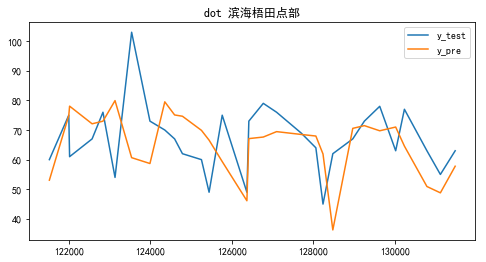

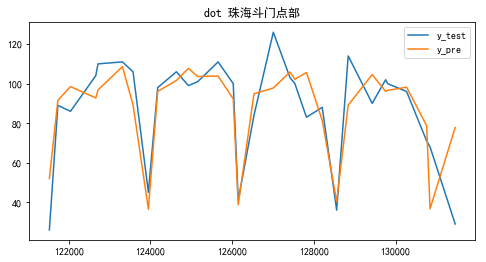

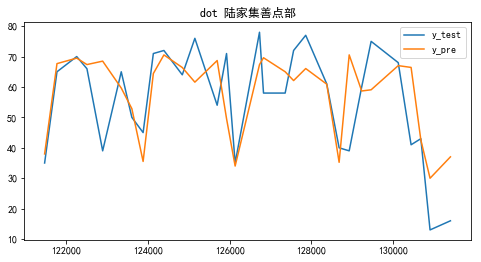

In [39]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_test','y_pre']
L = np.random.randint( low = 0, high = 337, size = 3 )
for i in L:
    s1 = pd.DataFrame(result[result['dot'] == result['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(result['dot'].unique()[i]), figsize = (8,4))

In [26]:
dot_train[dot_train['dot_id'] == 1].drop(['dot'], axis = 1).head(10)

,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,...,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling5,rolling7
248,1,2017-12-08,67.0,2017,12,8,4,342,49,0,...,50.0,53.0,48.0,64.0,14.0,36.0,40.0,49.952756,48.380767,47.270268
580,1,2017-12-09,47.0,2017,12,9,5,343,49,0,...,67.0,50.0,53.0,48.0,64.0,14.0,36.0,58.509804,54.839175,52.751437
917,1,2017-12-10,29.0,2017,12,10,6,344,49,1,...,47.0,67.0,50.0,53.0,48.0,64.0,14.0,52.743640,52.156330,51.196852
1108,1,2017-12-11,52.0,2017,12,11,0,345,50,0,...,29.0,47.0,67.0,50.0,53.0,48.0,64.0,40.860215,44.301336,45.316496
1612,1,2017-12-12,45.0,2017,12,12,1,346,50,0,...,52.0,29.0,47.0,67.0,50.0,53.0,48.0,46.432829,46.897572,47.061053
1777,1,2017-12-13,45.0,2017,12,13,2,347,50,0,...,45.0,52.0,29.0,47.0,67.0,50.0,53.0,45.716239,46.260135,46.528934
2255,1,2017-12-14,48.0,2017,12,14,3,348,50,0,...,45.0,45.0,52.0,29.0,47.0,67.0,50.0,45.358076,45.837921,46.137399
2581,1,2017-12-15,46.0,2017,12,15,4,349,50,0,...,48.0,45.0,45.0,52.0,29.0,47.0,67.0,46.679119,46.561091,46.611497
2959,1,2017-12-16,42.0,2017,12,16,5,350,50,0,...,46.0,48.0,45.0,45.0,52.0,29.0,47.0,46.339549,46.373633,46.456552
3285,1,2017-12-17,22.0,2017,12,17,6,351,50,1,...,42.0,46.0,48.0,45.0,45.0,52.0,29.0,44.169741,44.913532,45.331134


In [ ]:
result_to_csv = pd.DataFrame()
for i in range(30):
    x_test = pre_feature(dot_train, useful_dot_name)
    last_train_date = pd.to_datetime('2018-12-01') + pd.DateOffset(days = i + 1)
    x_test = x_test.loc[x_test['order_date'] == last_train_date, ['dot', 'dot_id', 'order_date', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7']]
#     x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = i)
    
    x_test = time_feature(x_test)
    
    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_pre' : y_pre})
    result_to_csv = pd.concat([result_to_csv, result])
    x_test = pd.merge(x_test, result, on = ['dot_id', 'order_date'], how = 'left')
    
    dot_train = pd.concat([dot_train, x_test])
    